# Group 12 - HUM-274: Milestone 2

In [2]:
from math import fabs
from itertools import product
from enum import Enum
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
import scipy.io.wavfile
import numpy as np
from numpy.fft import rfftfreq, irfft
from numpy.random import normal
from IPython.display import Audio
import random
from scipy.io.wavfile import *
import librosa
from librosa import display
from music21 import midi, note, stream, instrument, meter, key, tempo, chord, duration
from music21 import duration as dur
from music21.note import Rest
import platform
from copy import deepcopy

platform_str = "\\" if platform.platform()[:7] == "Windows" else "/"

ModuleNotFoundError: No module named 'librosa'

# I) Brief Overview

Three distinct procedures enable us to achieve the desired effects.

Firstly, **Brownian motion** encompasses the exposition's mellow beginnings and the story's disruptive element. Indeed, this random process is able to evolve very progressively and naturally, and is thus very much adapted to our storytelling needs. This is also why Markov chains were overlooked as they would not have that evolutive property we're looking for.

Secondly, we introduce the **L-System**, firstly used for deconstruction of rhythmic regularity and then its reconstruction. It is symbolically important to use one procedure for both tasks, thereby representing the symmetry of the narrative scheme. This tool can achieve chaos, all the while giving enough control and creativity to the user so they can seek convergence, as demonstrated below. This incomplete control lent by L-Systems is more fine-grained than neural networks', which we could have used too at the cost of less creative freedom.

Lastly, a **decision tree based harmonization utility** was programmed for the <em>peripeteia</em>'s second half. We seek harmonic complexity in the descending arc of the narrative scheme to contrast with preceding urban dissonant and ambient sounds. We also seek harmonic richness in the finale, leading the narration to an epic conclusion. Both tasks can be handled by the utility we have developed, which is meant to be a composer's toolkit with abilities to activate and deactivate chord transition parameters. Therefore, the decision tree and the L-System abstraction cooperate to create both of these subsections.

All of this will happen in the context of abstracting from Ravel's *Boléro* by following the narrative scheme.

<img src="media/narrative_scheme.jpg" alt="narrative_scheme" width="500" heigth="309"/>

Image source: 
*What Is a Narrative Arc? • A Guide to Storytelling Structure.* Reedsy
https://blog.reedsy.com/narrative-arc/

Let's dive in!

# II) Subsections

## 1.1) Exposition
The exposition starts with Brownian noise to which we gradually add notes from the *Boléro*, to metaphorically ease into the initial situation. We tried to use different colours of noise by using different exponents in our gaussian noise method and explain our choice for Brown noise below.

#### Algorithm change
To create brown noise, we first started with the idea to create a series of many sine waves which were represented each by numpy arrays with FRAMERATE values per second, sampling the human hearing range with corresponding frequencies. Unsurprisingly in restrospect, this proved several orders of magnitude too costly to compute.

The solution was to actually start in the frequency domain, have a vector values to sample the human hearing range, rescaling them depending on the required sound colour then simply using an inverse Fourier transform to go back to the time domain. This method bypasses the calculation of nearly 20,000 sine waves, each of size FRAMERATE * duration, and replaces it by a single computation on an array of size FRAMERATE * duration followed by an inverse Fourier transform.

In [ ]:
# Using the Nyquist-Shannon theorem
FRAMERATE = 44100

def play(score):
    # shortcut to play a music21 stream
    midi.realtime.StreamPlayer(score).play()

def play_sound(wave, framerate = FRAMERATE):
    #Plays a sound wave expressed as an array of values
    return Audio(wave, rate = framerate, autoplay=True)

def show_spectrogram(wave):
    #Shows spectrogram of input wave
    X = librosa.stft(wave)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=FRAMERATE, x_axis='time', y_axis='log')

def gaussian_noise(power, duration = 1, framerate = FRAMERATE, min_frequency = 20, max_frequency = 20000):
    """
    Method to create gaussian noise inspired by https://github.com/felixpatzelt/colorednoise, the algorithm comes from :
    On generating power law noise. by Timmer and Koenig
    Astron. Astrophys (1995)

    :param power: power to which to elevate the frequencies of the form 1/(f^power) (0 -> white noise, 1 -> pink noise, 2 -> brown noise)
    :param duration: duration in seconds of the sample to create
    :param framerate: number of sample per second
    :param min_frequency: minimum frequency possible in the output, here set as the minimum frequency of the human hearing spectrum
    :param max_frequency: maximum frequency possible in the output, here set as the maximum frequency of the human hearing spectrum
    :return: a numpy array of length duration * framerate representing the sound value at each frame
    """
    # total number of frames in the output
    length = duration * framerate

    # generating sample frequencies in the Fourier domain
    sample_frequencies = rfftfreq(length)

    # frequency is in hertz = 1/s => the order is reversed for time periods
    min_period = 1 / float(max_frequency)
    max_period = 1 / float(min_frequency)

    # cutting of the array of frequencies at the minimum frequency
    nb_low_period = np.sum(sample_frequencies < min_period)
    if 0 < nb_low_period < len(sample_frequencies):
        sample_frequencies[:nb_low_period] = sample_frequencies[nb_low_period]

    # cutting of the array of frequencies at the minimum frequency
    nb_high_period = np.sum(sample_frequencies > max_period)
    if 0 < nb_high_period < len(sample_frequencies):
        index = len(sample_frequencies) - nb_high_period
        sample_frequencies[index:] = sample_frequencies[index - 1]

    # scaling factors
    scaling_factors = sample_frequencies ** (-power/2.0)


    # Generating scaled random power + phase
    scaled_power = normal(scale=scaling_factors, size=np.array([len(sample_frequencies)]))
    scaled_phase = normal(scale=scaling_factors, size=np.array([len(sample_frequencies)]))

    # Combining power and phase
    signal  = scaled_power + 1J * scaled_phase

    # Using the inverse Fourier transform to go back to the time domain
    output = irfft(signal, n=length, axis=-1)

    return output

In [ ]:
# not chosen as it doesn't induce the wanted effect on the listener, isn't calming and grounding as an exposition
# should be and nearly sounds distracting
white_noise = gaussian_noise(0, duration = 10)
play_sound(white_noise)

In [ ]:
# for similar reasons to white noise, we didn't choose pink_noise as it still isn't very pleasant to listen to
pink_noise = gaussian_noise(1, duration = 10)
play_sound(pink_noise)

In [ ]:
# we chose to work with brown noise as it is much "smoother", nearly holding some reminiscence of the
# sound of waves, and works well as a calm eposition
brown_noise = gaussian_noise(2, duration = 100)
play_sound(brown_noise)

In [ ]:
# on the brown noise's spectrogram, we can see the decay in the associated power as the frequency increases
show_spectrogram(brown_noise)

In [ ]:
# wave plot of the brown noise
librosa.display.waveplot(brown_noise, sr=FRAMERATE);

In the exposition part of the composition, we use a ``.wav`` file which we will then merge with the rest of part 1 during which we gradually add notes from the *Boléro* by hand for two main reasons.

Firstly, a wav file is much more appropriate to generate brown noise (it would probably be unfeasible in music21), similarly, it is much easier to add notes from a midi file using music21 streams than raw waves.

Secondly, this will allow us to make the appearance of notes after the exposition much smoother: we could for example make the percussions out of samples of brown noise...

In [ ]:
# we divide by 2 to reduce the amplitude of the waves (the traduction to a wav file sometimes struggled if the waves
# had too big an amplitude), the file saving is commented out (the file is already in the media folder)

# write(f"media{platform_str}brown_noise.wav", FRAMERATE, brown_noise / 2.0)

## 1.2) Transitioning to the *Boléro*
We add notes according to the metrical structure to progressively replace the brownian noise from the exposition. This anchors the listener to a familiar theme.

In [ ]:
# opening our midi file and putting it on a stream
mf = midi.MidiFile()
mf.open(f"media{platform_str}Bolero-Ravel_Flute_Bat_Strings.mid")
mf.read()
s = stream.Stream()
s.append(midi.translate.midiFileToStream(mf))
mf.close()

We use the metrical structure as a guide to add notes with a certain probability. We then augment these probabilities as we are adding more and more of the melodic elements to the music to create a sense of convergence onto the Bolero.

![metrical_structure_3_4.png](media/metrical_structure_3_4.png)

Image source :
*An Attentional Effect of Musical Metrical Structure* 

Katz J, Chemla E, Pallier C (2015) An Attentional Effect of Musical Metrical Structure. PLOS ONE 10(11): e0140895. https://doi.org/10.1371/journal.pone.0140895

We consider the number of times a note appears in the above metrical structure as its relative probability.

In [ ]:
def intro_metrical_structure(s):
    """
    Introduces the melodic theme (here of the Bolero) by gradually adding notes following the metrical structure
    :param s:
    :return: the new stream created
    """
    # stream to accumulate the midi parts
    new_stream = stream.Stream()

    # time sig and tempo
    ts = meter.TimeSignature('3/4')
    new_stream.append(tempo.MetronomeMark(number = 72))
    new_stream.insert(0, ts)

    # an instrument to play our score
    new_stream.insert(0, instrument.Guitar())

    # probabilities for each of the beats of the measure to be added (metrical structure)
    initial_probabilities = np.array([3, 1, 2, 1, 2, 1], dtype = 'float32') / 10


    # looping over the different parts of the score
    for parts in s:
        for part in parts:

            # accumulator for the duration of the notes encountered
            duration = 0

            # creating a part with the right Time signature
            new_part = stream.Part()
            new_part.insert(0, ts)

            # reseting the probabilities for each part
            probabilities = deepcopy(initial_probabilities)

            # on each note or rest
            for element in part.flat.notesAndRests[0:100]:

                # increasing the probabilities once each two measures to create a sense
                # of convergence (the melody begins to make sense)
                elem_duration = element.duration.quarterLength
                if duration + elem_duration >= 6:
                    probabilities *= 1.6

                # getting the new accumulated duration
                duration = (duration + elem_duration) % 6

                # adding the current note with a particular probability
                # or substituting it by a rest of same duration
                if random.random() < probabilities[int(duration)] * elem_duration:
                    new_part.append(element)
                else:
                    r = note.Rest()
                    r.duration = element.duration
                    new_part.append(r)

            # inserting the part
            new_stream.insert(0, new_part)
    return new_stream

In [ ]:
# showing (a part of) the original partition before using the intro_metrical_structures (to compare)
def show_original(s):
    original = stream.Stream()
    for parts in s:
        for part in parts:
            new_part = stream.Part()
            for element in part.flat.notesAndRests[0:100]:
                new_part.append(element)
            original.insert(0, new_part)
    original.show()
show_original(s)

In [ ]:
# the new partition in which we gradually add more and more notes from the original partition
new_stream = intro_metrical_structure(s)
new_stream.show()

In [1]:
play(new_stream)

NameError: name 'play' is not defined

## 2) Disruptive Element

We are now in the second part of the narrative scheme where a disruptive element breaks the preceding tranquility, starting rising action. The listener should lose their balance as the original theme loses its familiar musical attributes.

### Brownian Motion
The introduction of chaotic elements is in parts done using brownian motion (the reasons for which are detailed below), the next cells create the framework with which we work with Brownian motion: some constants relative to our outputs and a method to simulate Brownian motion.

In [222]:
# simulating brownian motion from t=0 to t=TIME_HORIZON
TIME_HORIZON = 700.0
# number of sample points for the simulation
TIMESTEPS = 1000

In [223]:
def brownian_motion(dimensions=1, start_value = 0, time_horizon = TIME_HORIZON, timesteps = TIMESTEPS):
    """
    function to simulate brownian motion
    
    :param dimensions: number of dimensions in which we simulate
    :param start_value: value at which the brownian motion starts
    :param time_horizon: time until which we simulate
    :param timesteps: number of sample points with which to simulate
    :return: a tuple of the different time points at which we simulate, the actual brownian
        motion values at these time points as well as the difference between any 2 points in
        the brownian motion values (as it is more practical to work with)
    """

    # partitioning the space into timesteps number of points
    times = np.linspace(0.0, time_horizon, timesteps)
    step_length = times[1] - times[0]

    # as brownian motion at time t1 - brownian motion at time t0 ~ Normal(mean = 0, variance = t1-t0)
    # scale is the standard deviation, so we take the square root of the step_length
    diff_b = np.random.normal(size = (timesteps-1, dimensions), scale = np.sqrt(step_length))

    brownian_motion = np.zeros(shape=(timesteps,dimensions))

    # we start each brownian motion dimension with the given start value
    brownian_motion[0,:] = np.full((1, dimensions), start_value)

     # the rest of the values of brownian motion are the cumulative sum of normal values
    brownian_motion[1:,:] = np.cumsum(diff_b, axis = 0) + start_value

    return times, brownian_motion, diff_b

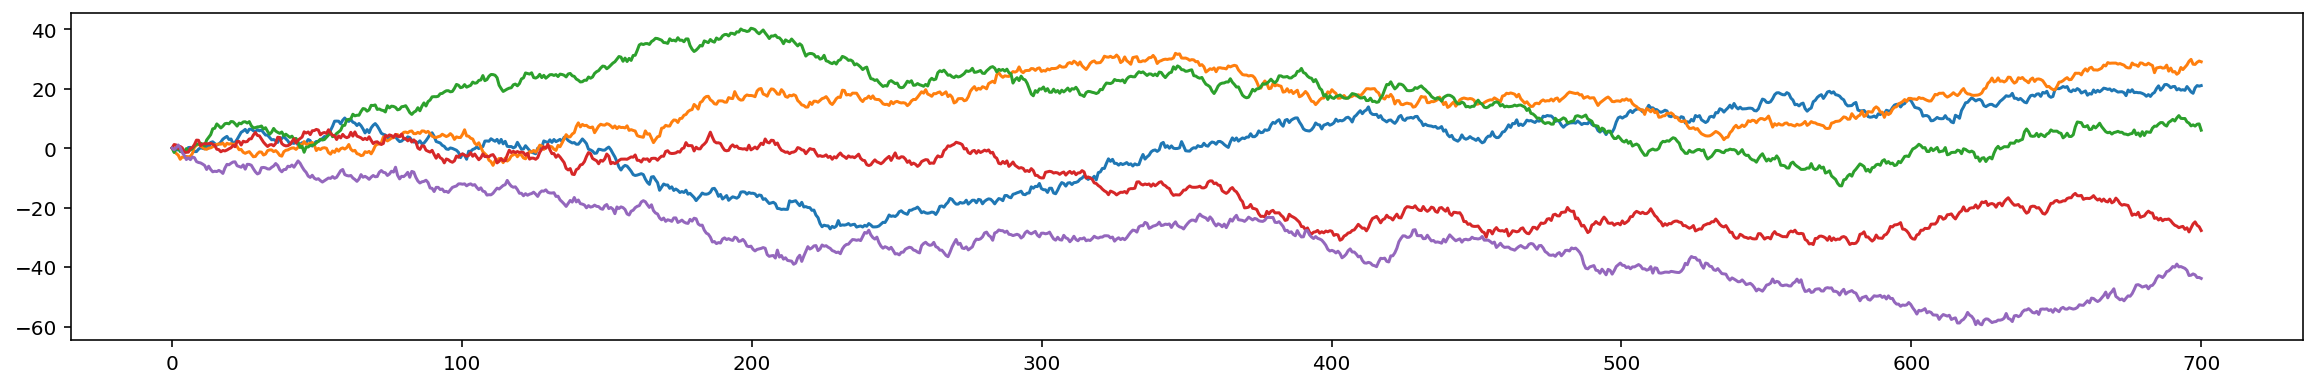

In [224]:
times, brownian_motion_arr, diff_brownian_motion = brownian_motion(dimensions=5)
plt.plot(times, brownian_motion_arr)
plt.show()

The below function takes a melody and makes it transition to chaos in four ways :

    1. Using brownian motion to sporadically remove rythmic values and slowly turn all notes into half-notes
    2. Restraining the range of notes down to the convergence note, creating dissonances
    3. Repeating it over and over, each time distorting it a little more
    4. Again, using brownian motion: removing notes pseudo-randomly to break down the melody

As can be seen, we use brownian motion extensively in this part, as it can act as a random process but still possesses some sense of convergence, one of the examples of which is the fact that brownian motion tends to a parabola when simulating it many times (1000 simulations in the example below):

![brownian_motion_parabola.png](media/brownian_motion_parabola.png)

This also formed an interesting link to our theme as brown noise, used in the introduction, is another name for Brownian noise, the both being linked by the fact that they are generated using random intervals. This again underlines the duality of chaos and convergence; we use a process, first to make sound converge to a known melody, just before introducing chaos in several forms using the same process.

As a side note, we tried to use plain random numbers to achieve the above goals but didn't quite get the effect we wanted (it was in a sense "too random", we couldn't use the properties of a Gaussian distribution whereby more values are close to the mean compared to a strictly uniform distribution). The melody was diverging too fast from the original for the listener to feel really destabilised. In other words, if the transition into chaos is too sudden, it is harder to be truly conscious of the power of chaos whereas in a slower transition, the listener still has some grasps onto the known melody, grasps which are removed one after the other until none remain. 
Moreover, using Brownian motion makes the very interesting case for the duality of chaos and convergence explained above.

In [225]:
# opening our midi file and putting it on a stream
mf = midi.MidiFile()
mf.open(f"media{platform_str}Bolero-Ravel_Loop.mid")
mf.read()
s1 = stream.Stream()
s1.append(midi.translate.midiFileToStream(mf))
mf.close()

In [226]:
# Note to which we converge : E4
E_PITCH = 64

In [227]:
def transition_to_chaos(s1, convergence_note = E_PITCH):
    """
    Takes a stream and makes it "transition to chaos"

    :param s: stream in which to introduce chaotic elements
    :convergence_note: note onto which to slowly converge
    :return:
    """
    # stream to accumulate the midi parts
    new_stream1 = stream.Stream()

    # time sig and tempo
    ts = meter.TimeSignature('3/4')
    new_stream1.append(tempo.MetronomeMark(number = 72))
    new_stream1.insert(0, ts)

    # an instrument to play our score
    new_stream1.insert(0, instrument.Guitar())


    # getting the arrays of brownian motion (we create one dimension of brownian motion per track in the midi file)
    _,_, diff_brownian_motion = brownian_motion(dimensions = len(mf.tracks))


    # looping over the different parts
    for parts in s1:
        # and getting the corresponding brownian motion array (one per track/part)
        for part, single_brownian_motion in zip(parts, diff_brownian_motion.transpose()):

            # creating a part with the right Time signature
            new_part = stream.Part()
            new_part.insert(0, ts)

            # to shift the array on each iteration
            index = 0

            # looping five times on the same two measures
            for _ in range(5):
                for element in part.flat.notesAndRests:

                    # shifting the array
                    move = single_brownian_motion[index]
                    index += 1

                    # if the brownian motion goes up and the length is smaller than two (the length of a half-note)
                    # we increase the duration of the element so as to slowly remove rythmic values, all notes starting to
                    # play longer until the length of a half-note
                    elem_duration = element.duration.quarterLength
                    if (elem_duration < 2 and move >= 0):

                        new_elem_duration = round((elem_duration + move) * 4) / 4
                        element.duration = dur.Duration(quarterLength = new_elem_duration)

                    # if the brownian motion is more than -1, we add the element
                    # otherwise it is removed to make the listener lose their balence by violently and
                    # sporadically simplifying the rythm
                    elif (move >= -1):

                        # if the element is a chord, no new modifications occur, we add it
                        if(element.isClassOrSubclass((chord.Chord,))):
                            c = chord.Chord(element.notes, duration = element.duration)
                            new_part.append(c)
                        else:

                            # if the element is a rest, no new modifications occur, we add it
                            if(element.name == 'rest'):
                                r = note.Rest(duration = element.duration)
                                new_part.append(r)
                            else:

                                # if element is a note, we shift it's pitch towards E4 (convergence note)
                                elem_pitch = element.pitch.midi
                                to_add = 0
                                if (elem_pitch < E_PITCH):
                                    to_add = 1
                                elif (elem_pitch > E_PITCH):
                                    to_add = -1

                                element.pitch.midi = elem_pitch + to_add
                                n = note.Note(duration = element.duration, pitch = element.pitch)
                                new_part.append(n)

            # inserting the part
            new_stream1.insert(0, new_part)

    return new_stream1

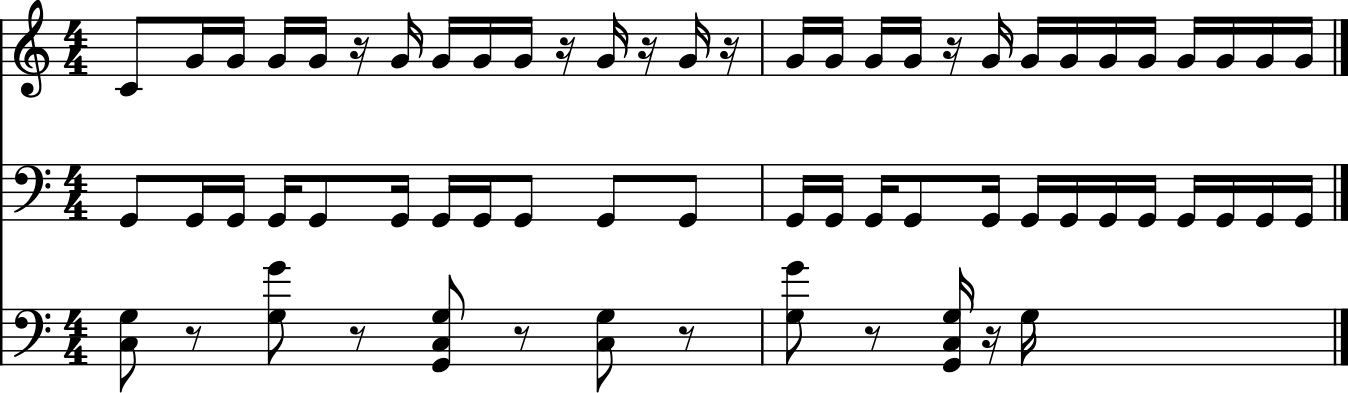

In [228]:
# Original score to compare with the new chaotic one
show_original(s1)

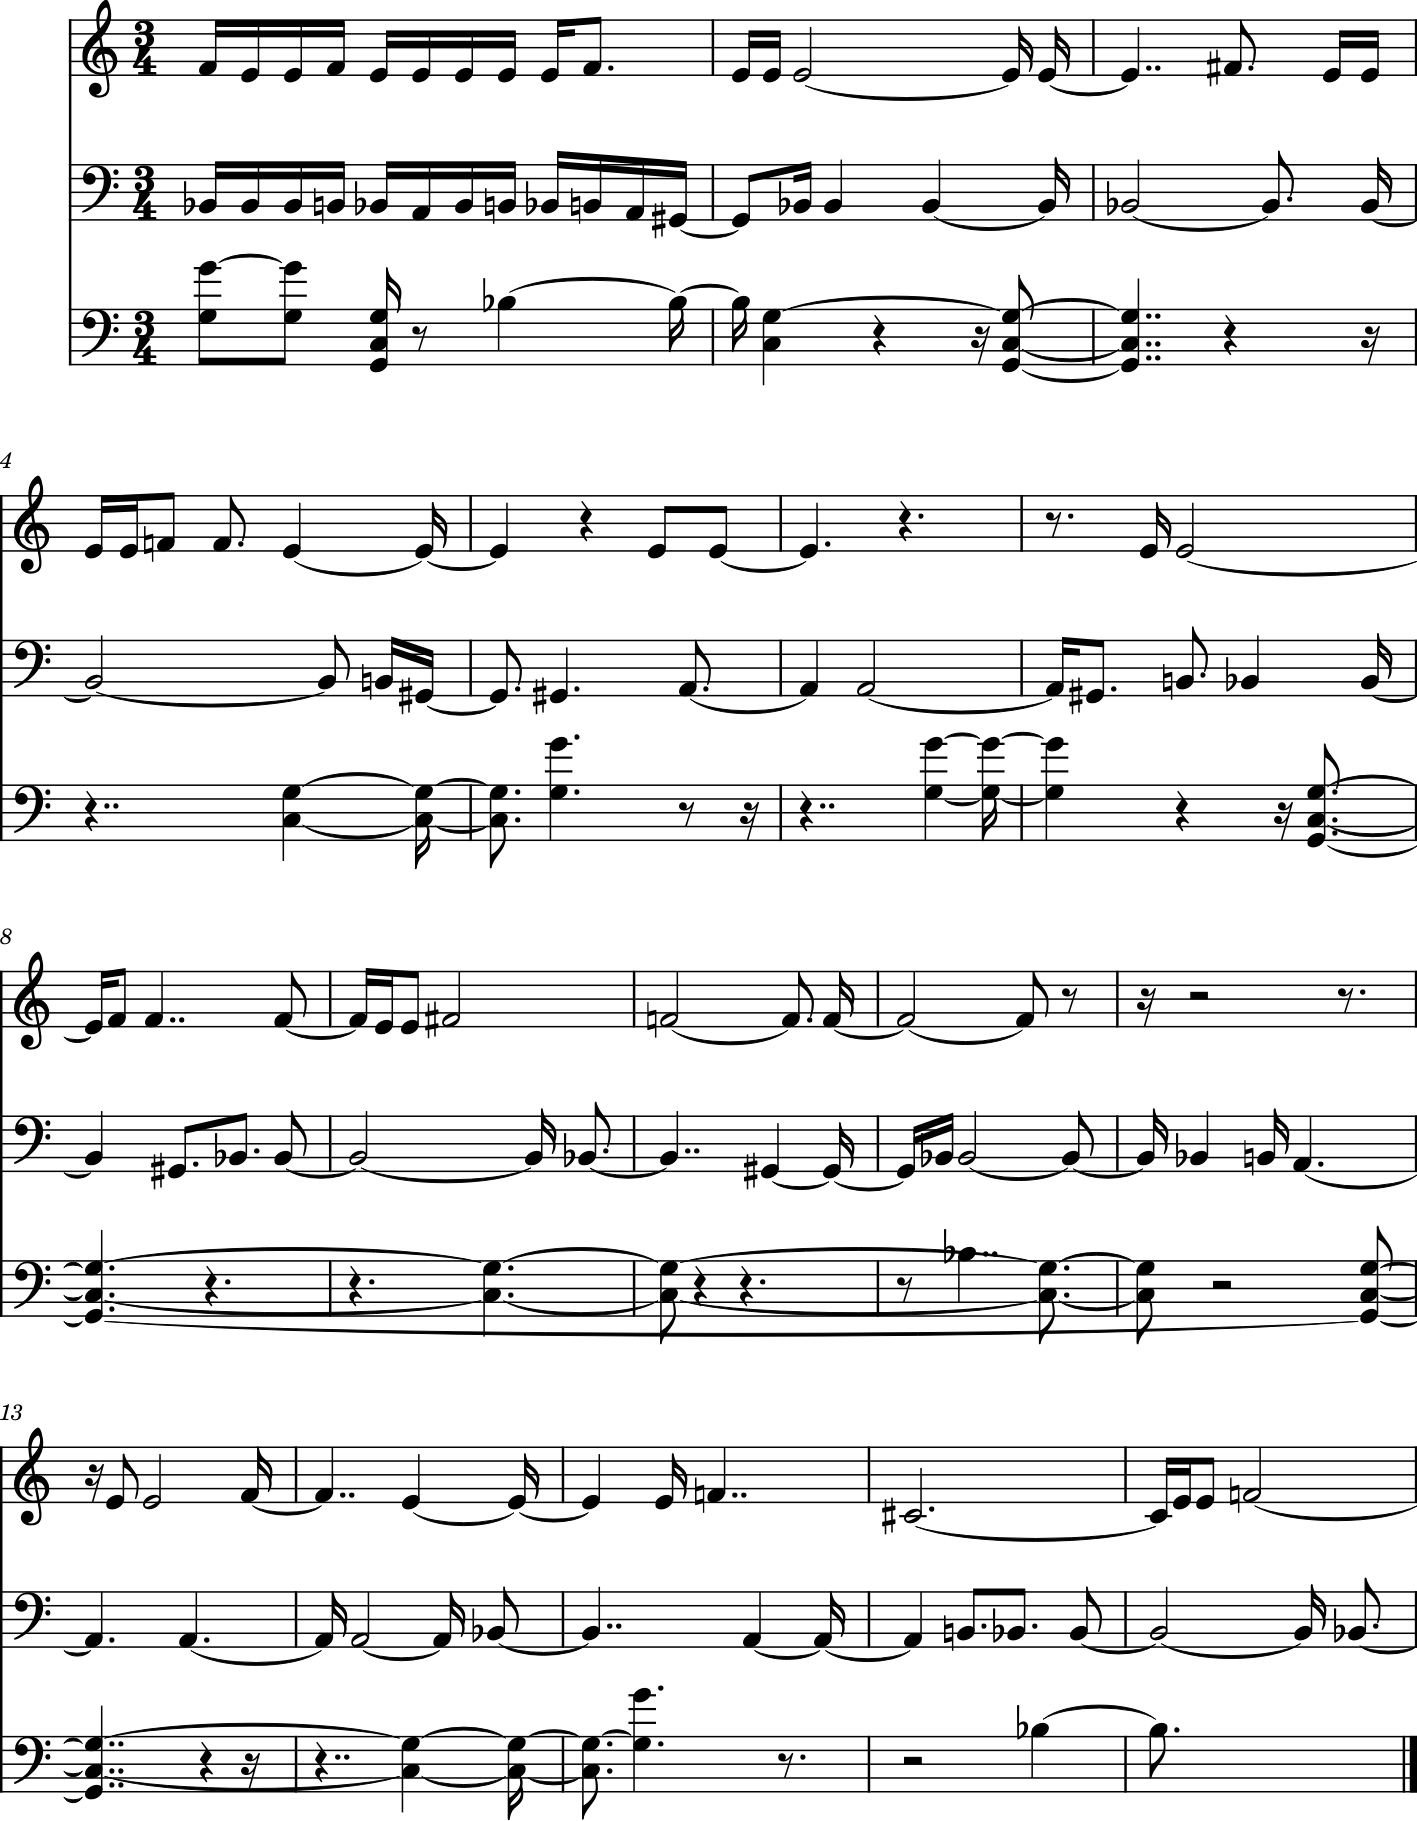

In [229]:
# Score after the introduction of chaotic elements
stream_copy = stream.Stream(s1)
new_stream1 = transition_to_chaos(stream_copy)
new_stream1.show()

In [230]:
play(new_stream1)

## 3) Losing Timbre
This part finishes the descent into chaos by acting on timbre, reaching the story and composition's crisis. We lose the familiarity of orchestral instruments and delve into the urban realm.

To transition from orchestral timbres to urban sounds, we will first impoverish the original sounds. Swapping the instruments abruptly does not fit in the composition, we need more irregularity.

To do so, we will tweak multiple parameters gradually:
-    shortening the notes' lengths
-    adding a bit of attack
-    lowering the sustain
-    detuning notes randomly
-    crushing the sound
-    filtering the sound

The first three options reduce the space taken by the instruments to make the transition smoother while the two last ones change the timber. The fourth change induces the feeling that the track loses itself a bit.
These changes are done in a DAW, but some could have been generated by the code below:

```python
def random(max)                          # returns a random number between 0 and max
def shorten(note : Note, duration : int) # to shorten a note by a specific duration
def shift_pitch(note : Note, cent : int) # to modify the pitch of a note by a number of cents

def impoverish_notes(stream : Stream):
    ratio = 0.1
    mean = 0
    range_rng = 10
    for (note,i) in (stream,range(stream.length)):
        # notes get shortened more and more
        shorten(note, random(mean)*ratio)

        # each 10 notes, the random pitch shift gets more intense
        shift_pitch(note, random(int(mean*ratio))*range_rng)
        mean += 1
```

As said, instead of this code, we used a random function inside our DAW. 

![Pitch_variations_annotated.png](media/Pitch_variations_annotated.png)

The crush/filter effects are done with the ``Distructor`` native plugin of FL Studio and custom presets. 

![Filter_and_Distortion_annotated.png](media/Filter_and_Distortion_annotated.png)

Another idea we had was to blend all the instruments through reverb and then swap them as if we walked into a cloud and got out in another place. However, the reverb took too much space, making for a transition more abrupt than we would have liked:

In [231]:
Audio(f"media{platform_str}orchestral_to_urban_in_reverb.mp3")

Once we start modifying the original instruments, we can also start adding urban sounds playing the same lines/rhythm by fading them in. Once the urban sounds take over, we fade out the orchestra. 

![Automations_and_clips_annotated.png](media/Automations_and_clips_annotated.png)

Here is a result on sample violins and drums (not the actual composition):

In [232]:
Audio(f"media{platform_str}tests_violin_to_urban_sounds3.mp3")

## 4) Adding complexity back

The previous part sees the deconstruction of the piece down to urban noises. This part stalls a little bit in this realm
of noise by injecting some rhythmic complexity first through a carefully chosen L-System, which we will reuse later. This is the beginning of the falling action where some sense is rediscovered.

Indeed, the L-System abstraction is really powerful as you can easily construct complex phenomena with varying effects.
First, here is our general purpose L-System implementation:

In [233]:
class Rule:
    """
    Encodes L Systems' replacement rules.
    """

    def __init__(self, base: str, replacement: str):
        """
        :param base: string,
        :param replacement: string
        """
        self.base = base
        self.replacement = replacement


class LSystem:
    """
    L System's functionality.
    """

    def __init__(self, *rules):
        """
        An L System = a set of rules

        :param rules: List[Rule]
        """
        self.rules = {}
        [self.rules.update({rule.base: rule.replacement}) for rule in rules]

    def replace(self, base, show_mode: bool = False):
        """
        The brains of an L System, doing the simple task of applying each rule recursively

        :param base: some base string
        :param show_mode: boolean deciding whether to put separating brackets or not between rule applications
        :return: result of applications of all replacement rules on base string
        """
        new_string = ""
        for c in base:
            if c in self.rules:
                if show_mode:
                    new_string += "<"
                new_string += self.rules.get(c)
                if show_mode:
                    new_string += ">"
            else:
                new_string += c
        return new_string

    def run(self, initial: str, nb_iterations: int, show_mode: bool = False):
        """
        Applies the replace method nb_iterations times with base string initial

        :param initial: first base string
        :param nb_iterations: how many times rules replacements should occur
        :param show_mode: boolean deciding whether to put separating brackets or not between rule applications
        :return: last result of rule applications
        """
        string = initial
        for i in range(nb_iterations):
            string = self.replace(string, show_mode)
        return string

This abstraction produces strings which are consequently mapped to musical elements. This is where a human can have
control over the L-System. See, for example, this function mapping L-System sequences to durations.

In [234]:
def sequence_from_string_complex(string: str):
    """
    To use with chars: A, B, C, D, E, F, +, -, [, ]
    A: half note
    B: quarter
    C: eighth
    D: sixteenth
    E: triplet
    F: quintuplet
    +: add previous and next duration
    -: make previous note a rest (value: -1 * duration of rest)
    [: extend previous duration by 50%
    ]: divide previous duration by 2
    :param string: input string
    :return: sequence of durations (floats)
    """

    def char_to_duration(c: str, tb: list):
        if c == 'A':
            tb.append(2)
        elif c == 'B':
            tb.append(1)
        elif c == 'C':
            tb.append(1 / 2)
        elif c == 'D':
            tb.append(1 / 4)
        elif c == 'E':
            tb.append(1 / 3)
        elif c == 'F':
            tb.append(1 / 5)
        elif c == '[':
            if len(tb) > 0:
                tb[-1] = tb[-1] + 0.5 * tb[-1]
        elif c == ']':
            if len(tb) > 0:
                if tb[-1] > float(1.0 / 1024):
                    tb[-1] = tb[-1] / 2
        elif c == '-':
            if len(tb) > 0:
                tb[-1] = -tb[-1]
        return tb[-1]

    def is_duration_char(c: str):
        return c in ['A', 'B', 'C', 'D', 'E', 'F']

    str_arr = [c for c in string]
    tab = []
    while not len(str_arr) == 0:
        nb_chars_read = 1

        if str_arr[0] == '+' and len(str_arr) >= 2:
            nb_chars_read = 2
            if len(tab) > 0 and is_duration_char(str_arr[1]):
                old_read = tab[-1]
                new_read = char_to_duration(str_arr[1], tab)
                new_dur = fabs(old_read) + fabs(new_read)
                if old_read < 0:
                    new_dur = -new_dur
                tab[-2] = new_dur
                tab = tab[:-1]

        else:
            char_to_duration(str_arr[0], tab)

        str_arr = str_arr[nb_chars_read:]  # remove chars read
    return tab

We define some helper functions to play and mix ``music21`` objects, which will be used to their full potential later in the
notebook. For now, we will modestly use them to play one stream of durations.

In [235]:
def translate(int_note, dur):
    """
    Given an integer value of a note, get a corresponding music21.note object
    :param int_note: integer value of the note
    :param dur: duration of desired note - if negative, interpret as rest
    :return music21.note
    """
    first_char_arr = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    pitch = first_char_arr[int_note % 12] + str(int(2 + int_note / 12))

    if dur < 0:
        return note.Rest(duration=duration.Duration(quarterLength = -dur))
    return note.Note(pitch, duration=duration.Duration(quarterLength = dur))


def combine_voices(length: int, rhythm, *voices, inst=None, time_sig='4/4'):
    """
    Define a voice to be a sequence of integers encoding pitches.
    This function takes multiple voices + an array of note durations (the parameter: rhythm)
    It then superposes all the voices and creates a set of synchronous notes (could be one, two [interval],
    three to nine [chord], or more) and plays these sets consecutively according to the rhythm sequence

    Otherwise said, it adds the same rhythmical durations to each voice, causing them to be superposed

    :param time_sig
    :param inst: list of used instruments
    :param length: common length of voices to consider
    :param rhythm: rhythmic line: sequence of durations
    :param voices: sequences of integers encoding notes
    :return stream of chords
    """

    if inst is None:
        inst = [instrument.Piano()]
    voices = voices[0]
    score = stream.Score()
    score.timeSignature = meter.TimeSignature(time_sig)

    parts = [stream.Part() for _ in range(len(voices))]
    for part_index in range(len(voices)):
        parts[part_index].timeSignature = meter.TimeSignature(time_sig)
        for i in range(length):
            parts[part_index].append(translate(voices[part_index][i], rhythm[i]))

    for i in range(len(parts)):
        parts[i].insert(0, inst[i])
        score.insert(0, parts[i])

    return score

Last but not least, let's put the pieces together!

In [236]:
def rules_complex():
    rule_a = Rule("A", "BB[F+E-D+A]FF")
    rule_b = Rule("B", "D[E]-C""D[E]-C")
    rule_c = Rule("C", "CD+C-CF-")
    rule_d = Rule("D", "AE+[D-D]D+ED")
    rule_e = Rule("E", "[E+-]B")
    rule_f = Rule("F", "F+[-B]B[[A]EF]")
    return LSystem(rule_a, rule_b, rule_c, rule_d, rule_e, rule_f)


def initial_complex():
    return "F]AEE-B"


def run_complex_for(n, show_mode=False):
    return rules_complex().run(initial_complex(), n, show_mode)


rhythm = sequence_from_string_complex(run_complex_for(4))
length = int(len(rhythm) / 60)
print(f"{length} notes kept")
score = combine_voices(length, rhythm, [[7 for i in range(length)]], inst=None, time_sig="3/4")

51 notes kept


This is what this rather complex L-System looks like:

<img src="media/lsys_complex.jpg" alt="lsys_complex" width="300" heigth = "300"/>

In [237]:
play(score)

This erratic rhythmic pattern creation matches the need for complexity mentioned in Milestone 1, thickening the plot.
Rhythm should be unsettling after the drone section of the composition; our aim is to create contrast, symbolizing dangerous peripeteia.

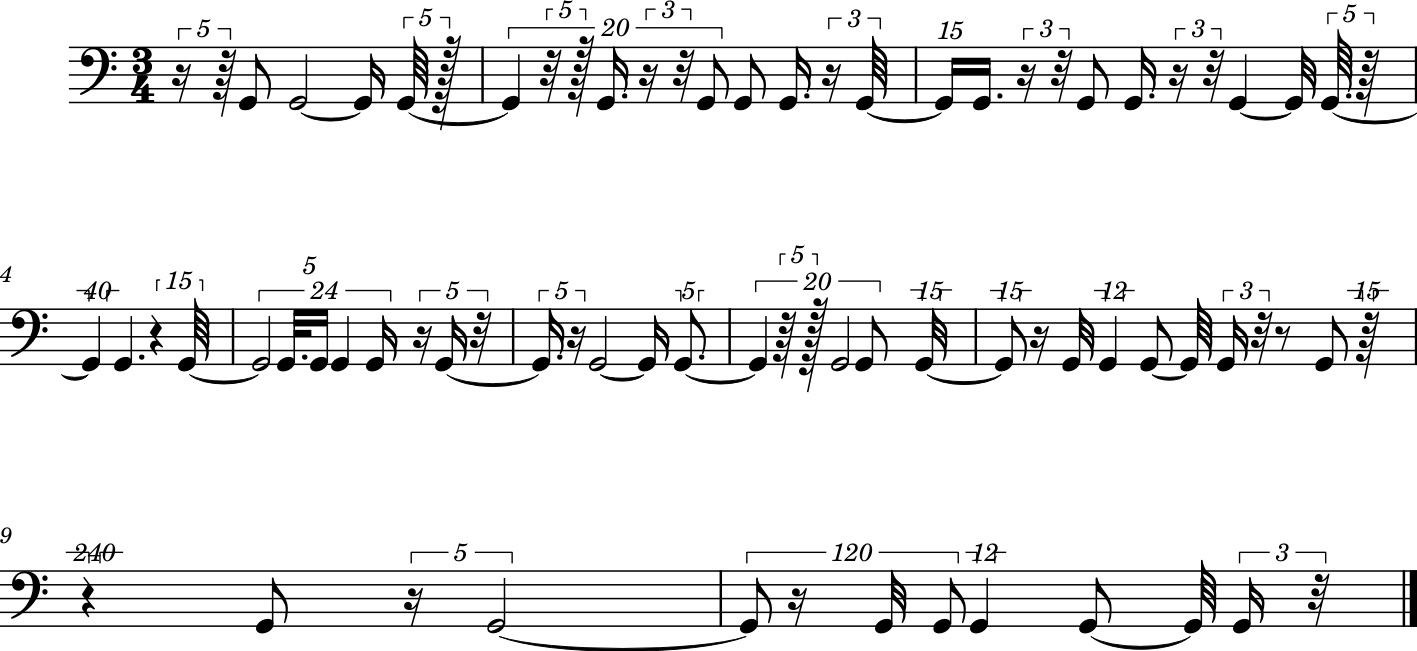

In [238]:
score.show()

Our next task is to add melodic values to these durations. 

One of the main procedures we use for this fourth part of the composition and the whole piece is algorithmic harmonization.

As we said in the general description of the piece, this fourth part creates complexity. The harmonization method will contribute to harmonic complexity, as it takes a bass line and a start chord and creates a full composition of four voices (bass, tenor, alto, soprano) following some of the most important classic harmonic rules. These rules come from *Tratado de armonía* (*Treatise on Harmony*), by Joaquín Zamacois, which are similar to the ones proposed by Walter Piston in *Harmony*. The code will compute all the different possibilities of transition between chords. Thus, we will move away from the previous simplicity, but we will not fall into complete chaos, as we follow strict harmonic rules.

The cell below corresponds to a Python file where we have implemented algorithmic harmonization. We decided to do the implementation from scratch, i.e. not to use ``music21`` library elements as notes or chords, because we preferred to have an absolute control over the data structures and achieve code efficiency and simplicity.

First, we have some constants and then parameters that we can change in order to have different outcomes (and also for debugging...). After that, we create the utilities for the keys and we create the principal data structures for our implementation: chords and trees of chords.

More details and clarifications about the implementation are included in the code. We have defined some functions, the main ones are: ``filter_w_rules`` (which applies all the harmonic rules), ``next_chords`` (that computes all the possible next chords from a given one and a bass note) and ``compose`` (which recursively calls ``next_chords`` and fills the chord tree).

In summary, all that code takes as input a bass line and a starting chord and creates a tree of all the possibilities of that harmonisation exercise (a figured bass). Once that code is executed, the following cell defines a method for choosing one composition among all possibilities, and the third cell represents the starting parameters and general calls to the functions. The last two little cells show the resulting scores.

Thanks to this algorithmic approach of harmonization, we can use many different outcomes to lift the fourth part of our piece. Starting with simple degrees, we can then end in more uncommon keys, still being able to change parameters in the meanwhile. All of this can be done whilst increasing the audible complexity, indeed, we also have to consider the rhythmic complexity provided by the L-System.

Moreover, when we were designing the implementation of the algorithmic composition, we decided not to over-complicate our code with chords of sevenths and ninths, that is, we want changes of colour between different harmonisation blocks rather than inside the same one. Reasoning in blocks mirrors a storytelling progressing in stages. The transition chords for the modulation between two harmonic blocks as well as the bass lines will be made by hand.

Besides, we have decided to utilize L-System rhythms that are not excessively dense (or, at least, not to do so most of the time), as we tried that for the mock project and it was too repetitive and it did not take advantage of the harmonic depth.

Finally, we will show after the three code cells a pair of outcomes of our algorithmic methods: the first is in G Major and the second one is in A minor.

In [239]:
"""
For the sake of simplicity, we will restrict ourselves to a simple harmonisation, with some assumptions:

Each note of the bass line represents its corresponding grade in the key, hence each chord is in fundamental state,
i.e. there are no inversions.
The chords are only formed with fifths, i.e., we do not use seventh or ninth chords.
"""
###########################################
#               CONSTANTS                 #
###########################################

# NOTES IN THE DIATONIC SCALE
DO = 0
DO_S_RE_F = 1
RE = 2
RE_S_MI_F = 3
MI = 4
FA = 5
FA_S_SOL_F = 6
SOL = 7
SOL_S_LA_F = 8
LA = 9
LA_S_SI_F = 10
SI = 11

# Map from a note (integer) to its corresponding string.
noteOf = {DO: "Do",
          DO_S_RE_F: "Do#/Reb",
          RE: "Re",
          RE_S_MI_F: "Re#/Mib",
          MI: "Mi",
          FA: "Fa",
          FA_S_SOL_F: "Fa#/Solb",
          SOL: "Sol",
          SOL_S_LA_F: "Sol#/Lab",
          LA: "La",
          LA_S_SI_F: "La#/Sib",
          SI: "Si"}

# SCALE DEGREES 0-BASED
TONIC = 0
SUPERTONIC = 1
MEDIANT = 2
SUBDOMINANT = 3
DOMINANT = 4
SUBMEDIANT = 5
LEADING_TONE = 6

# INTERVALS AND ITS CORRESPONDING AMOUNT OF SEMITONES
UNISON = 0
MINOR_THIRD_INTERVAL = 3
MAJOR_THIRD_INTERVAL = 4
PERFECT_FOURTH_INTERVAL = 5
PERFECT_FIFTH_INTERVAL = 7
OCTAVE = 12

###########################################
#          PARAMETERS WE CAN FIT          #
###########################################

EPSILON = 7  # allowed delta between two notes from different adjacent voices when looking for a transition
MAINTAIN_COMMON_NOTES = False  # prioritizes maintaining the common notes when chaining two chords // !!!!!
OVERTAKING_CADENCE = 0  # max. overtaking allowed between two voices when there is a cadence
OVERTAKING_NO_CADENCE = -4  # max. overtaking allowed between two voices when there is not a cadence

RULE_0_ACTIVE = True  # rule 0 : no big overtaking between voices
RULE_1_ACTIVE = True  # rule 1 : no duplication of the leading note
RULE_2_ACTIVE = True  # rule 2 : chords are in (absolute) range
RULE_3_ACTIVE = True  # rule 3 : leading note goes to tonic if grade is V or VII and the following is I, IV or VI
RULE_4_ACTIVE = True  # rule 4 : a note cannot appear more than 2 times in a chord
RULE_5_ACTIVE = True  # rule 5 : the fifth note has to be repeated for VII degree and cannot be repeated otherwise
RULE_6_ACTIVE = True  # rule 6 : all notes of the chord are present
RULE_7_ACTIVE = True  # rule 7 : third duplication (not I, IV, V) and V -> VI (m - M), VI -> V (m)
RULE_8_ACTIVE = True  # rule 8 : fourth augmented interval not allowed
RULE_9_ACTIVE = True  # rule 9 : two consecutive fourths, fifths and octaves are not allowed
RULE_10_ACTIVE = True  # rule 10 : direct fourths, fifths and octaves are not allowed
RULE_11_ACTIVE = True  # rule 11 : leading note and tonic note in the soprano if it is the final cadence

# NOTE RANGES WHERE BASS, TENOR, ALTO AND SOPRANO CAN BE PLACED
MIN_B = DO
MAX_B = DO + 2 * OCTAVE
MIN_T = SOL
MAX_T = SOL + 2 * OCTAVE
MIN_A = SOL + 1 * OCTAVE
MAX_A = MI + 3 * OCTAVE
MIN_S = DO + 2 * OCTAVE
MAX_S = LA + 3 * OCTAVE


###########################################
#            UTILITIES FOR KEYS           #
###########################################

# Creates a new key with one more sharp from the prev_key.
def new_key_sharp(prev_key):
    return [(note + PERFECT_FIFTH_INTERVAL) % 12 for note in prev_key]


# Creates a new key with one more flat from the prev_key.
def new_key_flat(prev_key):
    return [(note + PERFECT_FOURTH_INTERVAL) % 12 for note in prev_key]


# Returns whether a key is major or not.
def is_major(key_min_maj):
    return abs(key_min_maj[MEDIANT] - key_min_maj[TONIC]) == MAJOR_THIRD_INTERVAL


# Enum type which represents keys as lists. From 7 flats to 7 sharps.
class Key(Enum):
    DO_MAJOR = [DO, RE, MI, FA, SOL, LA, SI]
    LA_MINOR = [LA, SI, DO, RE, MI, FA, SOL_S_LA_F]

    # KEYS WITH SHARP :

    SOL_MAJOR = new_key_sharp(DO_MAJOR)
    MI_MINOR = new_key_sharp(LA_MINOR)

    RE_MAJOR = new_key_sharp(SOL_MAJOR)
    SI_MINOR = new_key_sharp(MI_MINOR)

    LA_MAJOR = new_key_sharp(RE_MAJOR)
    FA_S_MINOR = new_key_sharp(SI_MINOR)

    MI_MAJOR = new_key_sharp(LA_MAJOR)
    DO_S_MINOR = new_key_sharp(FA_S_MINOR)

    SI_MAJOR = new_key_sharp(MI_MAJOR)
    SOL_S_MINOR = new_key_sharp(DO_S_MINOR)

    FA_S_MAJOR = new_key_sharp(SI_MAJOR)
    RE_S_MINOR = new_key_sharp(SOL_S_MINOR)

    DO_S_MAJOR = new_key_sharp(FA_S_MAJOR)
    LA_S_MINOR = new_key_sharp(RE_S_MINOR)

    # KEYS WITH FLAT :

    FA_MAJOR = new_key_flat(DO_MAJOR)
    RE_MINOR = new_key_flat(LA_MINOR)

    SI_F_MAJOR = new_key_flat(FA_MAJOR)
    SOL_MINOR = new_key_flat(RE_MINOR)

    MI_F_MAJOR = new_key_flat(SI_F_MAJOR)
    DO_MINOR = new_key_flat(SOL_MINOR)

    LA_F_MAJOR = new_key_flat(MI_F_MAJOR)
    FA_MINOR = new_key_flat(DO_MINOR)

    RE_F_MAJOR = new_key_flat(LA_F_MAJOR)
    SI_F_MINOR = new_key_flat(FA_MINOR)

    SOL_F_MAJOR = new_key_flat(RE_F_MAJOR)
    MI_F_MINOR = new_key_flat(SI_F_MINOR)

    DO_F_MAJOR = new_key_flat(SOL_F_MAJOR)
    LA_F_MINOR = new_key_flat(MI_F_MINOR)


###########################################
#             DATA STRUCTURES             #
###########################################

# Class that represents a chord of three notes which are in the range 0 to 11 (both included).
class SimplifiedChord:
    def __init__(self, fundamental: int, third: int, fifth: int):
        self.fundamental = fundamental % 12
        self.third = third % 12
        self.fifth = fifth % 12

    # Determines whether the (simplified) given note is included in the chord
    def includes(self, note: int):
        new_note = note % 12
        return self.fundamental == new_note or self.third == new_note or self.fifth == new_note


# Class which represents a chord of four notes. The voices are, in order, the bass, the tenor, the alto and the soprano.
class Chord:
    def __init__(self, b: int, t: int, a: int, s: int):
        self.b = b
        self.t = t
        self.a = a
        self.s = s

    # Returns a Chord from a tuple.
    @staticmethod
    def of_tuple(notes):
        if len(notes) == 4:
            return Chord(notes[0], notes[1], notes[2], notes[3])
        else:
            return Chord.empty()

    # Returns the empty Chord.
    @staticmethod
    def empty():
        return Chord(-1, -1, -1, -1)

    # Creates a new Chord with notes in range 0 - 11 and ordered.
    def simplify(self):
        reduced = [self.b % 12, self.t % 12, self.a % 12, self.s % 12]
        return sorted(list({i for i in reduced}))

    # Returns the fundamental of the Chord.
    def fundamental(self):
        return self.b

    # Determines whether the Chord contains the note or not.
    def includes(self, note: int):
        return self.b == note or self.t == note or self.a == note or self.s == note

    # Transforms a Chord into its equivalent list.
    def to_list(self):
        return [self.b, self.t, self.a, self.s]

    # Creates a Chord from a list.
    @staticmethod
    def of(chord_list):
        if len(chord_list) == 4:
            return Chord(chord_list[0], chord_list[1], chord_list[2], chord_list[3])
        else:
            return Chord.empty()

    # Checks whether the notes respect the voice range constraints or not.
    def check_abs_ranges(self):
        abs_range_b = MIN_B <= self.b <= MAX_B
        abs_range_t = MIN_T <= self.t <= MAX_T
        abs_range_a = MIN_A <= self.a <= MAX_A
        abs_range_s = MIN_S <= self.s <= MAX_S

        return abs_range_b and abs_range_t and abs_range_a and abs_range_s

    # Checks if the number of semitones between adjacent voices is correct.
    def check_inter_ranges(self):
        return (abs(self.s - self.a) <= 14) and (abs(self.a - self.t) <= 14) and (abs(self.t - self.b) <= 24)

    # Check if the ranges of the voices are correct from their absolute and inter ranges.
    def check_ranges(self):
        return self.check_abs_ranges() and self.check_inter_ranges()

    # Creates a new SimplifiedChord from a fundamental note and a key.
    @staticmethod
    def simple_of(fundamental: int, key_simple: list):
        new_fundamental = fundamental % 12
        ind_fund = key_simple.index(new_fundamental)
        return SimplifiedChord(key_simple[ind_fund], key_simple[(ind_fund + 2) % 7],
                               key_simple[(ind_fund + 4) % 7])

    def __eq__(self, that):
        if isinstance(that, Chord):
            return self.b == that.b and self.t == that.t and self.a == that.a and self.s == that.s
        else:
            return False

    def __hash__(self):
        return hash((self.b, self.t, self.a, self.s))

    def __str__(self):
        return "Chord (b:{}, t:{}, a:{}, s:{})".format(self.b, self.t, self.a, self.s)


# Class which represents a tree of Chord.
class ChordTree:
    def __init__(self, root: Chord, depth: int):
        self.root = root
        self.depth = depth

    def __str__(self):
        return "\t" * (self.depth - 1) + str(self.root) + " (" + str(self.depth) + ")" + "\n"


# Class that represents a leaf (a form of ChordTree).
# The leaf is formed of a root and has a depth (within its parent ChordTree).
class Leaf(ChordTree):

    def __init__(self, root: Chord, depth: int):
        super().__init__(root, depth)

    # Returns a 1 level as it is a leaf.
    def level(self):
        return 1

    # Returns its total depth within its parent ChordTree.
    def total_depth(self):
        return self.depth

    def __str__(self):
        notes = noteOf[self.root.b % 12] + ", " + noteOf[self.root.t % 12] + ", " \
                + noteOf[self.root.a % 12] + ", " + noteOf[self.root.s % 12]

        return "\t" * (self.depth - 1) + str(self.root) + " (" + notes + ")" + " (" + str(self.depth) + ")" + "\n"


# Class that represents a node (a form of ChordTree). It has a root, a depth (within its parent ChordTree)
# and a list of children (of type ChordTree).
class Node(ChordTree):

    def __init__(self, root: Chord, depth: int, children: list):
        super().__init__(root, depth)
        self.children = children

    # Adds a child to the node.
    def add_child(self, child):
        self.children.append(child)

    # Adds a list of children to the node.
    def add_children(self, children):
        self.children.extend(children)

    # Returns the total number of leaves the node contains as a ChordTree.
    def level(self):
        children_count = 0
        for child in self.children:
            children_count += child.level()
        return children_count

    # Returns the largest total depth of its children as a ChordTree.
    def total_depth(self):
        max_depth = 1
        for child in self.children:
            child_total_depth = child.total_depth()
            if child_total_depth > max_depth:
                max_depth = child_total_depth
        return max_depth

    def __str__(self):
        notes = noteOf[self.root.b % 12] + ", " + noteOf[self.root.t % 12] + ", " \
                + noteOf[self.root.a % 12] + ", " + noteOf[self.root.s % 12]
        ret = "\t" * (self.depth - 1) + str(self.root) + " (" + notes + ")" + " (" + str(self.depth) + ")" + "\n"

        for child in self.children:
            ret += str(child)
        return ret


# Class that represents a empty node (a form of ChordTree). It has a depth (within its parent ChordTree).
class Empty(ChordTree):
    def __init__(self, depth: int):
        super().__init__(Chord.empty(), depth)

    def __str__(self):
        print("Empty")


###########################################
#          HARMONISATION METHODS          #
###########################################

def all_options(simple_options):
    """
    Auxiliary method which returns the cartesian product of chords (as lists) for all the simple_options.
    :param simple_options: a list which contains lists of possible elements for each voice
    :return: the set containing all the combinations of the elements of simple_options
    """
    return {i for i in product(*simple_options)}


def all_in_epsilon(note):
    """
    Auxiliary method that returns a range (of notes) within the epsilon value.
    :param note: the "central" note
    :return: the range of note
    """
    return range(max(0, note - EPSILON), note + EPSILON + 1)



def complete_transition(current_chord_list, next_chord_list, next_simple_chord: SimplifiedChord):
    """
    Auxiliary method that completes and returns all the possible transitions between the current chord
    and the sketch of the next chord.
    For the notes of the next_chord that are not defined, it creates a list with all the possible values.
    After that, it computes and returns all the different possibilities of chords.

    :param current_chord_list: the current chord, of type list
    :param next_chord_list: the sketch of the next chord, of type list
    :param next_simple_chord: the next chord in simplified format
    :return:a set of all the possible next chords
    """
    simple_options = []

    for i, note in enumerate(next_chord_list):

        if note == -1:
            # Adds the list for the notes within the range and filters it by the notes included in the next chord
            simple_options.append(list(filter(lambda x: next_simple_chord.includes(x),
                                              list(all_in_epsilon(current_chord_list[i])))))
        else:
            simple_options.append([note])  # the note is already defined

    return all_options(simple_options)  # computes all the options from the simple list (of length 4) of lists



def filter_w_rules(current_chord_list, options, next_next_degree, is_final_cadence, key_rules_input):
    """
    This method sequentially filters the set of all possible options following the more important harmonic rules.
    The different rules can be deactivated independently thanks to the corresponding constants.

    :param current_chord_list: the list that represents the current chord
    :param options: the set of all the possible chords for the next chord
    :param next_next_degree: the note that represents the degree two positions ahead, -1 if there is not
    :param is_final_cadence: boolean that determines if the next_chord is the final chord of a cadence
    :param key_rules_input: the key
    :return: set of the filtered options
    """
    key_degrees = key_rules_input.value

    # The temporary set that changes with respect to the rules
    temp = options.copy()
    ##############################################
    # RULE 0 : NO BIG OVERTAKING BETWEEN VOICES
    temp0 = set()
    for next_chord in temp:

        # Intervals between adjacent voices
        b_t_interval = next_chord[1] - next_chord[0]
        t_a_interval = next_chord[2] - next_chord[1]
        a_s_interval = next_chord[3] - next_chord[2]

        # The allowed overtaking between voices depends on whether there is a cadence or not
        not_big_overtake_b_t = b_t_interval >= OVERTAKING_NO_CADENCE if is_final_cadence else b_t_interval >= OVERTAKING_CADENCE
        not_big_overtake_t_a = t_a_interval >= OVERTAKING_NO_CADENCE if is_final_cadence else t_a_interval >= OVERTAKING_CADENCE
        not_big_overtake_a_s = a_s_interval >= OVERTAKING_NO_CADENCE if is_final_cadence else a_s_interval >= OVERTAKING_CADENCE

        if not_big_overtake_b_t and not_big_overtake_t_a and not_big_overtake_a_s:
            temp0.add(next_chord)
    temp = temp0 if RULE_0_ACTIVE else temp

    ##############################################
    # RULE 1 : NO DUPLICATION OF THE LEADING NOTE
    temp1 = set()
    for next_chord in temp:
        ack = 0
        for note in next_chord:
            if note % 12 == key_degrees[LEADING_TONE]:
                ack += 1
        if 0 <= ack < 2:
            temp1.add(next_chord)
    temp = temp1 if RULE_1_ACTIVE else temp

    ##############################################
    # RULE 2 : CHORDS RESPECT CORRECT RANGES
    temp2 = set()
    for next_chord in temp:
        if Chord.of_tuple(next_chord).check_ranges():
            temp2.add(next_chord)
    temp = temp2 if RULE_2_ACTIVE else temp

    ####################################################################
    # RULE 3 : LEADING NOTE GOES TO TONIC IF CURRENT GRADE IS III, V OR VII
    #          AND THE FOLLOWING IS I, IV OR VI
    temp3 = set()
    for next_chord in temp:

        prev_fund = Chord.simple_of(current_chord_list[0], key_degrees).fundamental
        current_fund = Chord.simple_of(next_chord[0], key_degrees).fundamental

        # Determines whether the leading notes is considered active (need to resolve)
        leading_active = (prev_fund == key_degrees[DOMINANT] or prev_fund == key_degrees[LEADING_TONE] or prev_fund ==
                          key_degrees[MEDIANT]) \
                         and (current_fund == key_degrees[TONIC] or current_fund == key_degrees[SUBDOMINANT]
                              or current_fund == key_degrees[SUBMEDIANT])

        for i, curr_note in enumerate(current_chord_list):
            if not leading_active or \
                    (curr_note % 12 == key_degrees[LEADING_TONE] and next_chord[i] % 12 == key_degrees[TONIC]
                     and leading_active):
                temp3.add(next_chord)
    temp = temp3 if RULE_3_ACTIVE else temp

    ##################################################################
    # RULE 4 : A NOTE CANNOT APPEAR MORE THAT 2 TIMES IN A SAME CHORD
    temp4 = set()
    for next_chord in temp:
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))
        correct_dupl = True

        for note in simple_notes_list:
            if simple_notes_list.count(note) > 2:
                correct_dupl = False

        if correct_dupl:
            temp4.add(next_chord)
    temp = temp4 if RULE_4_ACTIVE else temp

    #############################################################################################
    # RULE 5 : THE FIFTH NOTE HAS TO BE REPEATED FOR VII DEGREE AND CANNOT BE REPEATED OTHERWISE
    temp5 = set()
    for next_chord in temp:
        fund = Chord.simple_of(next_chord[0], key_degrees).fundamental
        fifth = Chord.simple_of(next_chord[0], key_degrees).fifth
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))

        if fund % 12 == key_degrees[LEADING_TONE]:
            if simple_notes_list.count(fifth) == 2:
                temp5.add(next_chord)
        elif simple_notes_list.count(fifth) < 2:
            temp5.add(next_chord)
    temp = temp5 if RULE_5_ACTIVE else temp

    ##############################################
    # RULE 6 : ALL NOTES OF THE CHORD ARE PRESENT
    temp6 = set()
    for next_chord in temp:
        simple_next_chord = Chord.simple_of(next_chord[0], key_degrees)
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))

        if simple_next_chord.fundamental in simple_notes_list and simple_next_chord.third in simple_notes_list \
                and simple_next_chord.fifth in simple_notes_list:
            temp6.add(next_chord)
    temp = temp6 if RULE_6_ACTIVE else temp

    ########################################################################################################
    # RULE 7 : THIRD DUPLICATION IS AUTHORISED WHEN THE DEGREE IS NOT I, IV AND V; AND IS MANDATORY WHEN
    #               V -> VI chaining in major and minor tonalities (3rd duplicated in VI)
    #               VI -> V chaining in minor tonality (3rd duplicated in VI)
    #               VII -> I (already implemented because of the 1st and 5st rules, 3rd dup. in VII)
    temp7 = set()
    for next_chord in temp:
        prev_fund = Chord.simple_of(current_chord_list[0], key_degrees).fundamental
        next_fund = Chord.simple_of(next_chord[0], key_degrees).fundamental
        third = Chord.simple_of(next_chord[0], key_degrees).third
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))

        third_two_times = simple_notes_list.count(third) == 2

        # Third duplication not recommended
        third_not_recom = next_fund == key_degrees[TONIC] or next_fund == key_degrees[SUBDOMINANT] \
                          or next_fund == key_degrees[DOMINANT]

        # V -> VI chaining in major and minor tonalities (3rd dup. in VI)
        v_vi = prev_fund == key_degrees[DOMINANT] and next_fund == key_degrees[SUBMEDIANT]

        # VI -> V chaining in minor tonality (3rd dup. in VI)
        vi_v_minor = next_fund == key_degrees[SUBMEDIANT] and \
                     next_next_degree == key_degrees[DOMINANT] and not is_major(key_degrees)

        mandatory_third = v_vi or vi_v_minor

        if (mandatory_third and third_two_times) or (not mandatory_third and not (third_not_recom and third_two_times)):
            temp7.add(next_chord)
    temp = temp7 if RULE_7_ACTIVE else temp

    #################################################
    # RULE 8 : FOURTH AUGMENTED INTERVAL NOT ALLOWED
    temp8 = set()
    for next_chord in temp:

        has_augm_interval = False
        for i, current_note_i in enumerate(current_chord_list):

            # Current note (and next note) are the leading note
            current_note_leading = current_note_i % 12 == key_degrees[LEADING_TONE]
            next_note_leading = next_chord[i] % 12 == key_degrees[LEADING_TONE]

            # Ascending augmented forth interval
            aug_forth_asc = current_note_i % 12 == key_degrees[SUBDOMINANT] and \
                            next_note_leading and \
                            next_chord[i] - current_note_i == 6

            # Descending augmented forth interval
            aug_forth_des = current_note_leading and \
                            next_chord[i] % 12 == key_degrees[SUBDOMINANT] and \
                            current_note_i - next_chord[i] == 6

            # Ascending augmented second interval
            aug_second_asc = current_note_i % 12 == key_degrees[SUBMEDIANT] and \
                             next_note_leading and \
                             next_chord[i] - current_note_i == 3

            # Descending augmented second interval
            aug_second_des = current_note_leading and \
                             next_chord[i] % 12 == key_degrees[SUBDOMINANT] and \
                             current_note_i - next_chord[i] == 3

            # Ascending augmented fifth interval
            aug_fifth_asc = current_note_i % 12 == key_degrees[MEDIANT] and \
                            next_note_leading and \
                            next_chord[i] - current_note_i == 8

            # Descending augmented fifth interval
            aug_fifth_des = current_note_leading and \
                            next_chord[i] % 12 == key_degrees[MEDIANT] and \
                            current_note_i - next_chord[i] == 8

            # If the key is major, augmented intervals can only be fourths
            if is_major(key_degrees):
                if aug_forth_asc or aug_forth_des:
                    has_augm_interval = True

            # If the key is minor, augmented intervals can be fourths, fifths and seconds
            else:
                if aug_forth_asc or aug_forth_des or aug_second_asc or aug_second_des \
                        or aug_fifth_asc or aug_fifth_des:
                    has_augm_interval = True

        if not has_augm_interval:
            temp8.add(next_chord)
    temp = temp8 if RULE_8_ACTIVE else temp

    #########################################################################
    # RULE 9 : TWO CONSECUTIVE FOURTHS, FIFTHS AND OCTAVES ARE NOT ALLOWED
    temp9 = set()
    for next_chord in temp:
        interval_problem = False

        # Compares for the not allowed consecutive intervals between the two chords
        # for all the possible pairs of voices (voice i and a higher voice j)
        for i, note_current_i in enumerate(current_chord_list):
            for j in range(i, 4):
                if i != j:
                    # There is no common note
                    mov = current_chord_list[j] != next_chord[j] or note_current_i != next_chord[i]

                    interval_current = (current_chord_list[j] - note_current_i) % 12
                    interval_next = (next_chord[j] - next_chord[i]) % 12
                    if interval_current == interval_next and mov and \
                            (interval_current == UNISON or interval_current == PERFECT_FOURTH_INTERVAL or
                             interval_current == PERFECT_FIFTH_INTERVAL):
                        interval_problem = True
        if not interval_problem:
            temp9.add(next_chord)
    temp = temp9 if RULE_9_ACTIVE else temp

    #########################################################################
    # RULE 10 : DIRECT FOURTHS, FIFTHS AND OCTAVES ARE NOT ALLOWED
    temp10 = set()
    for next_chord in temp:
        interval_problem = False

        # Compares for the not allowed direct intervals between the two chords
        # for all the possible pairs of voices (voice i and a higher voice j)
        for i, note_current_i in enumerate(current_chord_list):
            for j in range(i, 4):
                if i != j:

                    # An interval is considered direct if both voices change in the same direction
                    # and both for more of a tone
                    interval_next = (next_chord[j] - next_chord[i]) % 12
                    change_chords_i = next_chord[i] - note_current_i
                    change_chords_j = next_chord[j] - current_chord_list[j]

                    if ((change_chords_i > 2 and change_chords_j > 2) or (
                            change_chords_i < -2 and change_chords_j < -2)) \
                            and (interval_next == UNISON or interval_next == PERFECT_FOURTH_INTERVAL
                                 or interval_next == PERFECT_FIFTH_INTERVAL):
                        interval_problem = True

        if not interval_problem:
            temp10.add(next_chord)
    temp = temp10 if RULE_10_ACTIVE else temp

    ###################################################################################
    # RULE 11 : LEADING NOTE AND TONIC NOTE IN THE SOPRANO IF IT IS THE FINAL CADENCE
    temp11 = set()
    if (not is_final_cadence) or current_chord_list[0] % 12 == key_degrees[LEADING_TONE]:
        temp11 = temp10
    else:
        for next_chord in temp:
            if current_chord_list[3] % 12 == key_degrees[LEADING_TONE] and next_chord[3] % 12 == key_degrees[TONIC]:
                temp11.add(next_chord)
    temp = temp11 if RULE_11_ACTIVE else temp

    return temp


# Dictionary that includes transitions from a chord and a the next bass note to all the possible next chords
transition = {}


def next_chords(current_chord: Chord, next_note: int, next_next_note: int, is_final_cadence: bool, key_for_chords: Key):
    """
    Computes all the possible next chords for the next note

    :param current_chord: the current chord
    :param next_note: the next note from the bass to chain
    :param next_next_note: the following note of the next note
    :param is_final_cadence: boolean that indicates if it is the final cadence
    :param key_for_chords: the key of the harmonization
    :return: the set of all the possible next_chords for the next note
    """
    global transition

    options = transition.get((current_chord, next_note))

    # If the transition is already computed, it uses it and does not again the computation (dynamic programming)
    if options is not None and not is_final_cadence:
        return options

    else:
        options = set()

        current_chord_list = current_chord.to_list()
        # Already copies the bass note
        next_chord_list = [next_note]
        next_simple_chord = Chord.simple_of(next_note, key_for_chords.value)

        # If the constant MAINTAIN_COMMON_NOTES is true, we keep the common notes in the following chord if possible
        # For the undetermined notes, it adds -1
        if MAINTAIN_COMMON_NOTES:
            if current_chord.fundamental() == next_note:
                options.add(tuple(current_chord.to_list()))
            else:
                for note in current_chord_list[1:]:
                    if next_simple_chord.includes(note) and note % 12 != key_for_chords.value[LEADING_TONE]:
                        next_chord_list.append(note)
                    else:
                        next_chord_list.append(-1)
        else:
            next_chord_list = [next_note, -1, -1, -1]

        # Computes of the possible options for the next chord thanks to the filter_w_rules method
        options = filter_w_rules(current_chord_list,
                                 complete_transition(current_chord_list, next_chord_list, next_simple_chord),
                                 next_next_note,
                                 is_final_cadence,
                                 key_for_chords)

        if is_final_cadence:
            # Adds the current transition to the global dictionary
            transition[(current_chord, next_note)] = tuple(opt for opt in options)
            return transition[(current_chord, next_note)]
        else:
            return tuple(opt for opt in options)


def compose(initial_chord, bass_line, prev_chord_tree, prev_cadence, tonality_compose):
    """
    Recursive method that computes algorithmically the composition (computes all the possible harmonizations)
    and inserts it into the tree. A node (or a leaf) of the chord tree keeps track of its previous chord.

    :param initial_chord: initial chord
    :param bass_line: bass line (a list of notes)
    :param prev_chord_tree: the chord tree
    :param prev_cadence: boolean that indicates whether this following chord is the last for the final cadence
    :param tonality_compose: key of the harmonization
    :return: void function, as it stores the results in the tree
    """
    ton_value = tonality_compose.value
    next_cadence = False

    if len(bass_line) > 1:
        if len(bass_line) == 2:
            next_cadence = bass_line[0] % 12 == ton_value[DOMINANT] or bass_line[0] % 12 == ton_value[LEADING_TONE] \
                           or (bass_line[0] % 12 == ton_value[MEDIANT])

        # All the possible next chords from the current chord
        list_next_chords = next_chords(initial_chord, bass_line[0], bass_line[1], prev_cadence, tonality_compose)

        for chord in list_next_chords:
            chord_type = Chord(chord[0], chord[1], chord[2], chord[3])
            node = Node(chord_type, prev_chord_tree.depth + 1, [])
            # Adds the next chord to a node and continues the composition from that chord
            prev_chord_tree.add_child(node)
            compose(chord_type, bass_line[1:], node, next_cadence, tonality_compose)

    elif len(bass_line) == 1:
        # Notifies next_chords that this is the final cadence
        list_next_chords = next_chords(initial_chord, bass_line[0], -1, prev_cadence, tonality_compose)

        for chord in list_next_chords:
            chord_type = Chord(chord[0], chord[1], chord[2], chord[3])
            # As it is the final chord, creates a leaf instead of a node
            leaf = Leaf(chord_type, prev_chord_tree.depth + 1)
            prev_chord_tree.add_child(leaf)


In [240]:
def to_arrays(voices):
    """
    :param voices: list of chords
    :return decomposed voices: each chord is split into 4 notes, and 4 distinct parts are returned
    """
    bass = []
    tenor = []
    alto = []
    soprano = []

    for chord in voices:
        bass.append(chord.b)
        tenor.append(chord.t)
        alto.append(chord.a)
        soprano.append(chord.s)

    return [bass, tenor, alto, soprano]

def combine_voices_harm(length: int, rhythm, *voices, inst=None, time_sig='4/4'):
    """
    Combines the voices with music21 objects.
    :param length: common length of voices to consider
    :param voices: sequences of integers encoding notes
    :param inst: instruments
    :param time_sig: time signature
    :return stream of chords
    """

    voices = voices[0]
    if inst is None:
        inst = [instrument.BrassInstrument() if i % 2 == 0 else instrument.Piano() for i in range(len(voices))]
    score = stream.Score(timeSignature=time_sig)

    parts = [stream.Part() for _ in range(len(voices))]
    for part_index in range(len(voices)):
        for i in range(length):
            parts[part_index].append(translate(voices[part_index][i], 1))

    for i in reversed(range(len(parts))):
        parts[i].insert(0, inst[i])
        score.insert(0, parts[i])

    return score


def select_path_in_tree_harm(length: int, composition_tree: Node):
    """
    From a chord tree, randomly chooses a path (of an expected length)
    :param length: the expected length of the path
    :param composition_tree: the composition tree
    :return: the path
    """
    curr_node = composition_tree
    path = [curr_node.root]

    for i in range(length):

        if isinstance(curr_node, Node):
            list_index = list(range(0, len(curr_node.children)))
            random.shuffle(list_index)

            index = 0
            index_elem = list_index[index]

            while index < len(list_index) - 1 and curr_node.children[index_elem].total_depth() != length:
                index += 1
                index_elem = list_index[index]

            curr_node = curr_node.children[index_elem]
            path.append(curr_node.root)

    return path

In [241]:
bass_do_major = [DO, FA, SOL, SI, DO + OCTAVE, FA, LA, FA, SOL, SI, DO + OCTAVE, FA, SOL, DO, SOL, DO]
bass_sol_major = [note + PERFECT_FIFTH_INTERVAL for note in bass_do_major]
bass_la_minor = [LA, FA, MI, LA, RE, LA, MI, FA, MI, LA, SOL_S_LA_F, LA, FA, SI, MI, LA]

start_chord_sol_major = Chord(SOL, SI + 1 * OCTAVE, SOL + 2 * OCTAVE, RE + 3 * OCTAVE)
start_chord_la_minor = Chord(LA, LA + 1 * OCTAVE, MI + 2 * OCTAVE, DO + 3 * OCTAVE)


def create_composition(key, start_chord, bass):
    voices = [[], [], [], []]
    composition_tree = Node(start_chord, 1, [])

    compose(start_chord, bass[1:], composition_tree, False, key)
    # print(composition_tree)
    print("composition_tree's level (total number of different compositions) : " + str(composition_tree.level()))

    path = select_path_in_tree_harm(len(bass), composition_tree)
    path = to_arrays(path)[0:len(path)]
    for i in range(4):
        voices[i].extend(path[i])

    parts = combine_voices_harm(len(voices[0]), [], voices,
                                inst=[instrument.Piano(), instrument.Piano(), instrument.Piano(), instrument.Piano()])

    return parts

In [242]:
parts_1 = create_composition(Key.SOL_MAJOR, start_chord_sol_major, bass_sol_major)

composition_tree's level (total number of different compositions) : 344


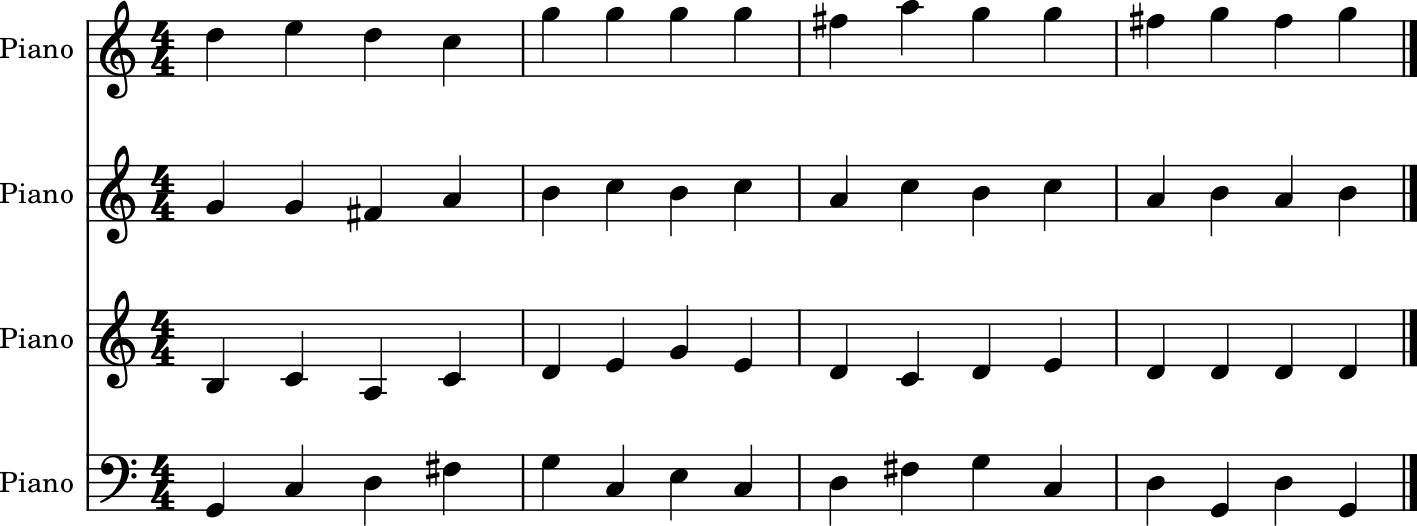

In [243]:
parts_1.show()
play(parts_1)

In [244]:
parts_2 = create_composition(Key.LA_MINOR, start_chord_la_minor, bass_la_minor)

composition_tree's level (total number of different compositions) : 1051


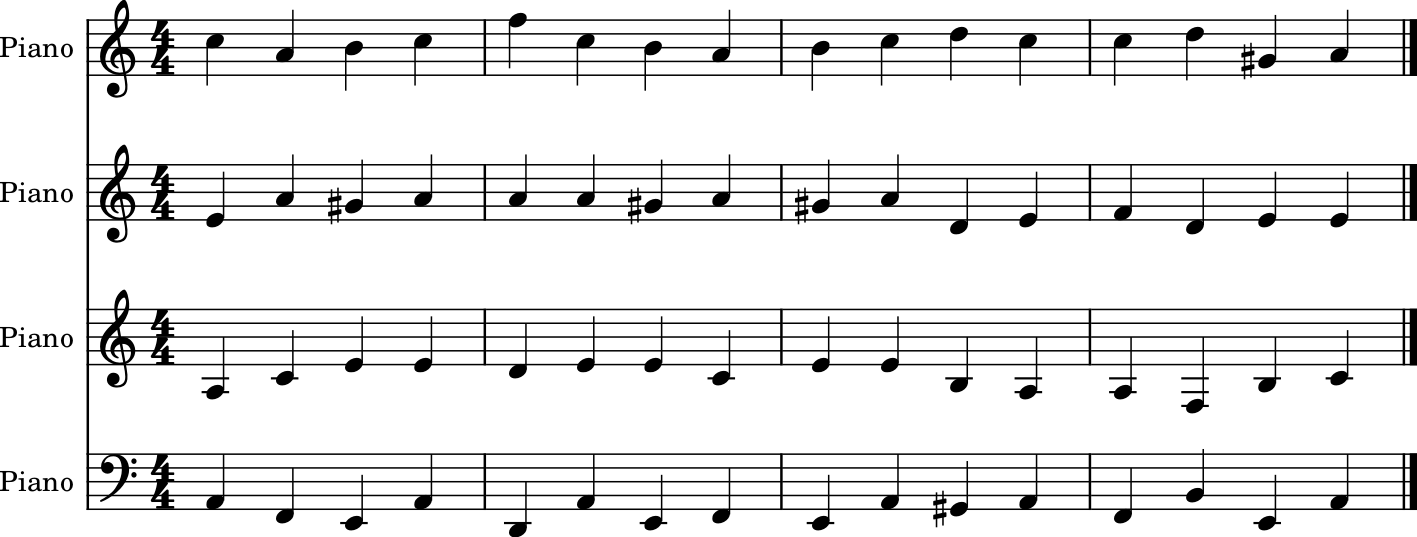

In [245]:
parts_2.show()
play(parts_2)

## 5) Convergence after chaos
The second to last step of the composition sees a reconvergence to the main theme, reaching narrative resolution. Rhythm and melody converge separately to a theme resembling that of the *Boléro*.

Let's start with rhythm. We need to find an appropriate L-System and a string to durations function. In the previous
section, the artistic choice of complex chaos made it simple to come up with a divergent L-System that generates
random-sounding notes. The goal is reversed this time: *Boléro*'s main theme is quite simple and very repetitive.

Consequently, the uses of the L-System abstraction and the Brownian noise are perfectly mirrored in this composition: the latter converges first then reaches chaos, the former creates chaos then converges to a steady state.

In [246]:
def rules_bolero():
    """
    Converge to the Bolero snare drum part: A B A C
    where A = the common first half of the two measures 
              (one eighth note + 3 sixteenths)
          B = A + 2 eighth notes, the second half of the 
              first measure
          C = A + 6 sixteenth notes, the second half of the
              second measure
    """
    return LSystem(
        Rule("A", "ESSS"),
        Rule("B", "ESSSEE"),
        Rule("C", "ESSSSSSSSSZ"),
        Rule("E", "E"),
        Rule("S", "S"),
        Rule("T", "S"),
        Rule("W", "STSTSTTSSE"),
        Rule("X", "WYTTAYYESSYZ"),
        Rule("Y", "BATTWBWTTTTSTTA"),
        Rule("Z", "ABAC")
    )


def initial_bolero():
    return "YWWX"


def run_bolero_for(n, show_mode=False):
    return rules_bolero().run(initial_bolero(), n, show_mode)


def sequence_from_string_bolero(string: str):
    """
    To use with chars in chars_bolero
    Notes with rhythmical values:

    E: eight note
    S: sixteenth note
    T: 32nd note
    
    A: triplet
    B: two triplets
    C: dotted eight note
    
    W: quarter note rest
    X: quintuplet
    Y: two quintuplets
    Z: eight note rest

    :param string: input string
    :return: sequence of durations (floats)
    """
    note_durations = {
        "E": 1 / 2,
        "S": 1 / 4,
        "T": 1 / 8,
        
        "A": 1/3,
        "B": 2/3,
        "C": 3/4,
        
        "W": -1/4,
        "X": 1/5,
        "Y": 2/5,
        "Z": -1/2
    }

    return [note_durations.get(c) for c in string]

Let's see what this sequence looks like and confirms that it actually converges to *Boléro*'s snare drum part:

In [247]:
bolero_rhythm = run_bolero_for(3, True)
print(f"end of the sequence: {bolero_rhythm[-60:]}")

end of the sequence: S><S><S><S><S><S><ESSS>><<ESSS><ESSSEE><ESSS><ESSSSSSSSSZ>>>


The very end of the sequence is indeed: ``<<ESSS><ESSSEE><ESSS><ESSSSSSSSSZ>> == <ABAC>``, which is the Boléro's main rhythm: recall that ``E`` is an eighth note and ``S`` a sixteenth. ``Z = <ABAC>`` simply ensures continuity of the rhythm at the next cycle. Convergence is confirmed!

Just for fun, here's what this L-System looks like:

<img src="media/lsys_bolero.jpg" alt="lsys_bolero" width="300" heigth="300"/>

Now let's see and hear what it sounds like. Play the next cell to listen; do note that the generated transition should be shorter than this sample in the final composition.

In [248]:
bolero_rhythm = sequence_from_string_bolero(run_bolero_for(3, False))
length = int(len(bolero_rhythm))
bolero_score = combine_voices(length, bolero_rhythm, [[7 for i in range(length)]], inst=[instrument.Woodblock()], time_sig="3/4")

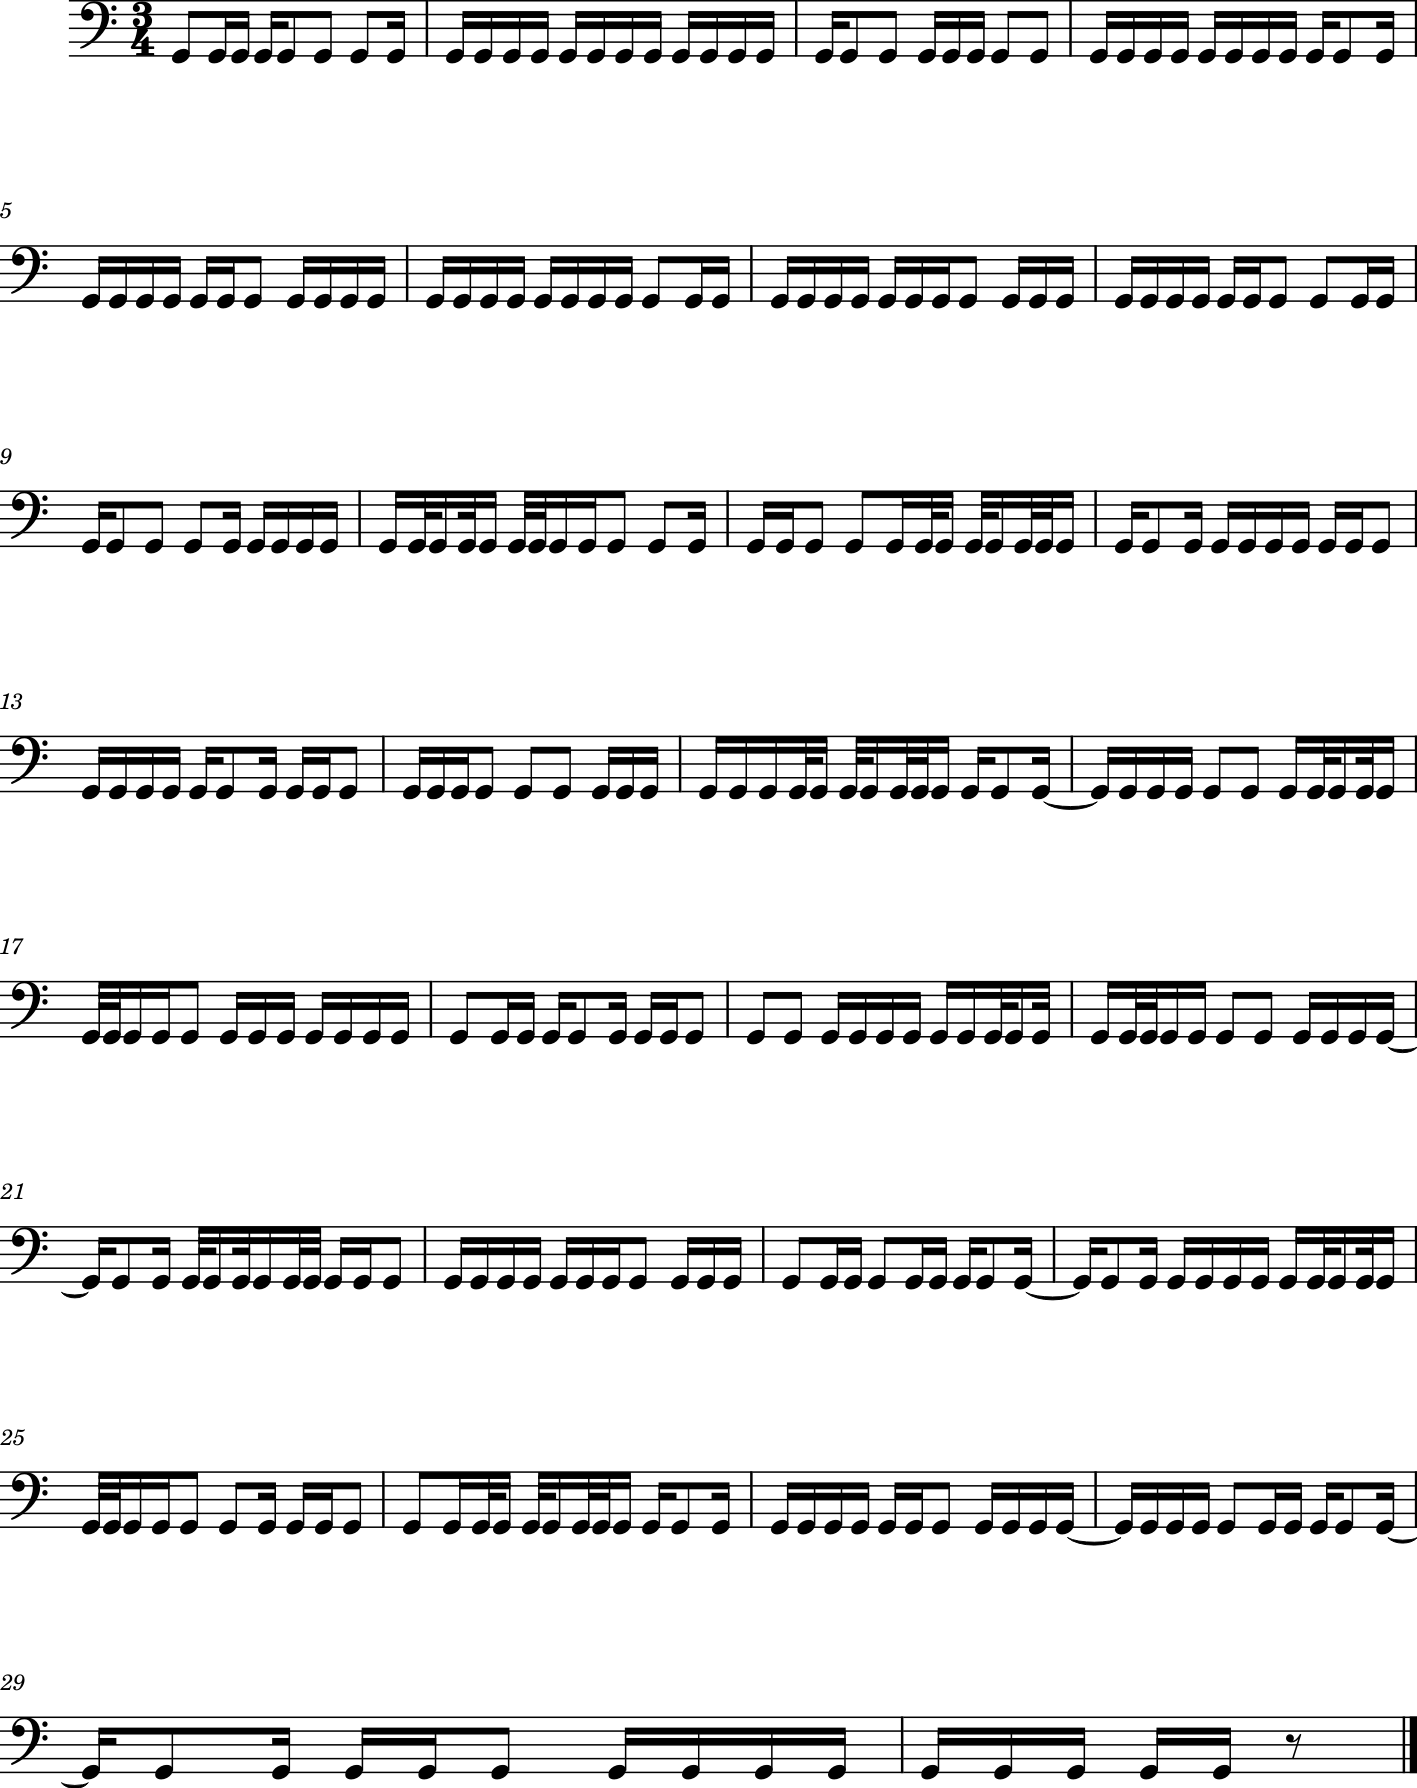

In [249]:
bolero_score.show()
play(bolero_score)

The 32nd notes add some tension and irregularity while more and more A, B, and C patterns appear.

In conclusion, in this part, the snare drum pattern has been smoothly reconstructed.

The finale will differ significantly from what was exposed in Milestone 1 in style and means, but not in goal. The objective remains bringing this narrative story to a close melodically. Ravel does it in epic *tutti* fashion while changing the key. Since this piece is essentially a liberal recomposition, we will recreate that our way, by using the harmonization tool introduced in part 4), only this time, the rhythms are handwritten.

This concludes our deep dive on the methods used to encompass the narrative scheme presented in Milestone 1, along with its study of chaos and convergence.

# III) Outlook

Here is a rough timeline of the piece so far:

![actual_structure.png](media/actual_structure.png)

What remains to be done are essentially some transitions. The precise details for transitioning have already been presented in the sub-structures development above. We will also smooth some edges, try out different possibilities for the non-deterministic parts of the composition, and select the ones we see fit.